In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# warning 없애는 코드
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_excel('c:/chosungeun/data/cansim-0800020-eng-6674700030567901031.xlsx')
df.columns

Index(['Adjustments', 'Unadjusted', 'Seasonally adjusted'], dtype='object')

unjusted 값이 우리가 사용할 데이터/

이 타임시리즈 데이터를 이용해서 미래 가격을 예측해보자

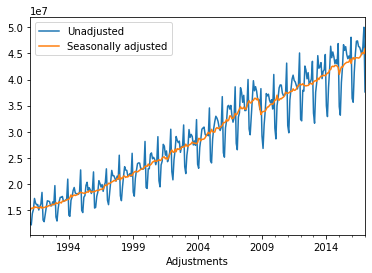

In [3]:
df['Adjustments']=pd.to_datetime(df['Adjustments'])
df=df.set_index('Adjustments')
df.plot()

## 학습셋과 테스트셋 split
1. 2011/1/1/을 기준으로 학습셋과 테스트셋을 구분하려고 함
2. 그리고 unadjusted 변수만 남기기

In [4]:
split_date = pd.Timestamp('01-01-2011')

In [31]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date: ,['Unadjusted']]

In [32]:
train.head(10)

,Unadjusted
Adjustments,
1991-01-01,12588862
1991-02-01,12154321
1991-03-01,14337072
1991-04-01,15108570
1991-05-01,17225734
1991-06-01,16342833
1991-07-01,15996243
1991-08-01,16064910
1991-09-01,15015317


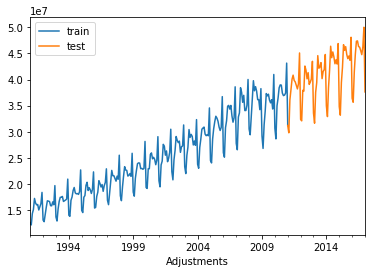

In [6]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

## 변수 scaling

MinMax scaling: -> 결과 : 2차원 numpy ndarray 타입으로 변환이 됨


In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.fit_transform(test)


In [8]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.fit_transform(test)

## pandas dataframe으로 변환

dataframe에서 작업을 해야 window를 만들기 편하기 때문
여기서 window size는 timestamp와 연관됨


In [9]:
train_sc_df= pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df =pd.DataFrame(test_sc, columns=['Scaled'], index = test.index)

In [10]:
for s in range(1,13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)]=test_sc_df['Scaled'].shift(s)


# 학습셋과 테스트셋 나누기

1. dropna를 NAN 데이터 제거

2. shift1~12는 X, scaled Y로 지정

In [11]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
Y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
Y_test = test_sc_df.dropna()[['Scaled']]

In [12]:
Y_train.head(10)

,Scaled
Adjustments,
1992-01-01,0.030027
1992-02-01,0.019993
1992-03-01,0.065964
1992-04-01,0.109831
1992-05-01,0.149130
1992-06-01,0.147189
1992-07-01,0.144648
1992-08-01,0.118984
1992-09-01,0.118027


## 딥러닝 학습을 위해 ndarray로 변환하기 

딥러닝 모델 트레이닝과 테스트에 사용되는 데이터는 일반적으로 numpy의 ndarray를 사용


In [13]:
X_train = X_train.values
X_test = X_test.values

In [14]:
Y_train = Y_train.values
Y_test = Y_test.values

keras에서 RNN계열(시퀀스배열, LSTM포함) 트레이닝할 때 3차원 데이터로
들어가야 함(size, timestamp, feature) reshape를 사용한다.

In [17]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [19]:
print("최종 X_train data")
print(X_train_t.shape)
print(X_train_t)

print("")
print("최종 Y_train data")
print(Y_train.shape)
print(Y_train.shape)

최종 X_train data
(229, 12, 1)
[[[0.20091289]
  [0.13173822]
  [0.11139526]
  ...
  [0.0704258 ]
  [0.        ]
  [0.01402033]]

 [[0.03002688]
  [0.20091289]
  [0.13173822]
  ...
  [0.09531795]
  [0.0704258 ]
  [0.        ]]

 [[0.01999285]
  [0.03002688]
  [0.20091289]
  ...
  [0.16362761]
  [0.09531795]
  [0.0704258 ]]

 ...

 [[0.80210057]
  [0.79916654]
  [0.81439355]
  ...
  [0.59734863]
  [0.92972161]
  [0.71629034]]

 [[0.81482896]
  [0.80210057]
  [0.79916654]
  ...
  [0.53166512]
  [0.59734863]
  [0.92972161]]

 [[1.        ]
  [0.81482896]
  [0.80210057]
  ...
  [0.73605008]
  [0.53166512]
  [0.59734863]]]

최종 Y_train data
(229, 1)
(229, 1)


## LSTM 모델 적용

input_shape = (timestamp, feauture) 로 만들 것

In [21]:
from keras.models import Sequential

from keras.layers import LSTM, Dense

import keras.backend as K

from keras.callbacks import EarlyStopping


In [24]:
K.clear_session()
model = Sequential()
model.add(LSTM(6, input_shape=(12,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [28]:
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)

model.fit(X_train_t, Y_train, validation_data=(X_test_t, Y_test), epochs=200,
          batch_size=30, verbose=1, callbacks=[early_stopping])

Train on 229 samples, validate on 61 samples
Epoch 1/200
229/229 [==============================] - 0s 135us/step - loss: 0.0037 - val_loss: 0.0149
Epoch 2/200
229/229 [==============================] - 0s 131us/step - loss: 0.0038 - val_loss: 0.0147
Epoch 3/200
229/229 [==============================] - 0s 161us/step - loss: 0.0038 - val_loss: 0.0147
Epoch 4/200
229/229 [==============================] - 0s 140us/step - loss: 0.0037 - val_loss: 0.0145
Epoch 5/200
229/229 [==============================] - 0s 144us/step - loss: 0.0036 - val_loss: 0.0145
Epoch 6/200
229/229 [==============================] - 0s 140us/step - loss: 0.0037 - val_loss: 0.0144
Epoch 7/200
229/229 [==============================] - 0s 144us/step - loss: 0.0037 - val_loss: 0.0142
Epoch 8/200
229/229 [==============================] - 0s 148us/step - loss: 0.0036 - val_loss: 0.0141
Epoch 9/200
229/229 [==============================] - 0s 144us/step - loss: 0.0036 - val_loss: 0.0141
Epoch 10/200
229/229 [======

229/229 [==============================] - 0s 131us/step - loss: 0.0013 - val_loss: 0.0032
Epoch 158/200
229/229 [==============================] - 0s 140us/step - loss: 0.0013 - val_loss: 0.0033
Epoch 159/200
229/229 [==============================] - 0s 131us/step - loss: 0.0013 - val_loss: 0.0031
Epoch 160/200
229/229 [==============================] - 0s 131us/step - loss: 0.0013 - val_loss: 0.0031
Epoch 161/200
229/229 [==============================] - 0s 131us/step - loss: 0.0012 - val_loss: 0.0033
Epoch 162/200
229/229 [==============================] - 0s 127us/step - loss: 0.0012 - val_loss: 0.0030
Epoch 163/200
229/229 [==============================] - 0s 131us/step - loss: 0.0012 - val_loss: 0.0031
Epoch 164/200
229/229 [==============================] - 0s 135us/step - loss: 0.0013 - val_loss: 0.0031
Epoch 165/200
229/229 [==============================] - 0s 131us/step - loss: 0.0012 - val_loss: 0.0032
Epoch 166/200
229/229 [==============================] - 0s 122us/ste

In [29]:
y_pred = model.predict(X_test_t)

In [30]:
print(y_pred.shape)
y_pred

(61, 1)


array([[0.14735776],
       [0.10136777],
       [0.37397695],
       [0.4632171 ],
       [0.5537568 ],
       [0.58551174],
       [0.53715473],
       [0.5231436 ],
       [0.4946432 ],
       [0.46437827],
       [0.503104  ],
       [0.75244105],
       [0.20397297],
       [0.19937834],
       [0.46158433],
       [0.45741558],
       [0.67305535],
       [0.63197654],
       [0.5542839 ],
       [0.6055763 ],
       [0.5036701 ],
       [0.52036697],
       [0.541622  ],
       [0.6876438 ],
       [0.26152694],
       [0.1862159 ],
       [0.44908765],
       [0.533379  ],
       [0.766929  ],
       [0.65470994],
       [0.66337454],
       [0.6984605 ],
       [0.5592244 ],
       [0.6198869 ],
       [0.628934  ],
       [0.7562815 ],
       [0.3304863 ],
       [0.24590805],
       [0.49399358],
       [0.6476895 ],
       [0.8543305 ],
       [0.752612  ],
       [0.7998358 ],
       [0.75585496],
       [0.6940961 ],
       [0.7253673 ],
       [0.6824981 ],
       [0.852